In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pycbc
from pycbc.types import FrequencySeries
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform

from gstlal import chirptime
from functools import partial


import h5py
import scipy

import bilby
from bilby.gw import utils as gwutils
from pesummary.gw.conversions import spins as pespin
from multiprocessing import Pool
import multiprocessing
from functools import partial
from bilby.gw import conversion

import torch
import os
# cit: '/home/qian.hu/neuron_process_waveform/npf_GWwaveform'
# local: '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/'
try:
    os.chdir('/home/qian.hu/neuron_process_waveform/npf_GWwaveform/')
except:
    os.chdir('/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/')
from gw.utils import gwutils as npgwutils


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
class GravitationalWaveTransientNPMod(bilby.gw.likelihood.GravitationalWaveTransient):
    def __init__(
            self, interferometers, waveform_generator, waveform_generator_np, time_marginalization=False,
            distance_marginalization=False, phase_marginalization=False, calibration_marginalization=False, priors=None,
            distance_marginalization_lookup_table=None, calibration_lookup_table=None,
            number_of_response_curves=1000, starting_index=0, jitter_time=True, reference_frame="sky",
            time_reference="geocenter", random_percent_error=None
    ):
        super().__init__(interferometers, waveform_generator)
        
        self.waveform_generator_np = waveform_generator_np
        self.random_percent_error = random_percent_error
    
    
    def likelihood_modification(self):
        h_dict = self.waveform_generator.frequency_domain_strain(self.parameters)
        if self.random_percent_error:
            lenerror = len(self.interferometers[0].power_spectral_density_array)
            plus_percent_error = np.random.random(lenerror)*self.random_percent_error/100  
            cross_percent_error = np.random.random(lenerror)*self.random_percent_error/100
            npstd_dict = {}
            npstd_dict['plus'] = plus_percent_error * (abs(np.real(h_dict['plus'])) + abs(np.imag(h_dict['plus']))*1j ) + 1e-27
            npstd_dict['cross'] = cross_percent_error * (abs(np.real(h_dict['cross'])) + abs(np.imag(h_dict['cross']))*1j ) + 1e-27
        else:
            npmean_dict, npstd_dict = self.waveform_generator_np.frequency_domain_strain(self.parameters)
            h_dict = npmean_dict
        
        logLe = 0
        for det in self.interferometers:
            fmask = det.frequency_mask
            psd_array = det.power_spectral_density_array[fmask]
            
            resp_h =  det.get_detector_response(h_dict, self.parameters)                
            resp_sigma = det.get_detector_response(npstd_dict, self.parameters)
            sigmax = np.real(resp_sigma)[fmask]
            sigmay = np.imag(resp_sigma)[fmask]
            
            
            N = det.frequency_domain_strain[fmask] - resp_h[fmask]
            nfactorx = np.sqrt(sigmax**2/(4*sigmax**2+det.duration*psd_array))
            nfactory = np.sqrt(sigmay**2/(4*sigmay**2+det.duration*psd_array))
            Nprime = nfactorx*np.real(N) + nfactory*np.imag(N)*1j
            Nprime_innner_prod = bilby.gw.utils.noise_weighted_inner_product(
                aa=Nprime,
                bb=Nprime,
                power_spectral_density=det.power_spectral_density_array[fmask],
                duration=det.duration).real
            
            logLe += (sum(np.log(psd_array)) + sum(np.log(nfactorx/abs(sigmax))) + sum(np.log(nfactory/abs(sigmay))) +\
                2*Nprime_innner_prod + np.log(det.duration)*len(psd_array) )
            

        return logLe
    
    def log_likelihood(self):
        return self.log_likelihood_ratio() + self.noise_log_likelihood() + self.likelihood_modification()
            
                    
            

In [3]:
def logsumup_array(array):
    i=0
    logsum = 0
    while i<len(array):
        if i==0:
            logsum=np.logaddexp(array[i], array[i+1])
            i+=2
        else:
            logsum=np.logaddexp(logsum,array[i])
            i+=1
    return logsum
        
def normalize_log_likelihood(loglikelihood):
    loglikelihood_norm = loglikelihood - logsumup_array(loglikelihood)
    return loglikelihood_norm

In [4]:
duration=32/2
f_lower=10*2
sampling_frequency=4096
ifos = bilby.gw.detector.InterferometerList(['CE'])
det = ifos[0]
det.duration = duration
det.sampling_frequency=sampling_frequency
det.frequency_mask = det.frequency_array>=f_lower
mask = det.frequency_mask
freq_array = det.frequency_array[mask]


injection_parameters = {'chirp_mass': 20,
 'mass_ratio': 0.7,
 'a_1': 0.08817513918906,
 'a_2': 0.0618136183509149,
 'tilt_1': 0.5721118014736555,
 'tilt_2': 0.6209483780316792,
 'phi_12': 0.497541312882614,
 'phi_jl': 2.727769314864493,
 'theta_jn': 1.2076899194027677,
 'psi': 2.592123436585328,
 'phase': 3.153492039022807,
 'ra': 4.2400911,
 'dec': -0.39120439,
 'luminosity_distance': 320,
 'geocent_time': 1256779567.5339382}

approx = 'IMRPhenomPv2' # IMRPhenomXPHM IMRPhenomPv2
approx_under = 'SEOBNRv4P' # SEOBNRv4PHM SEOBNRv4P
f_ref = 50
f_lower = 20
waveform_arguments = dict(waveform_approximant=approx,
                              reference_frequency=f_ref, minimum_frequency=f_lower)
waveform_arguments_under = dict(waveform_approximant=approx_under,
                              reference_frequency=f_ref, minimum_frequency=f_lower)

waveform_generator_IMR = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments)

waveform_generator_EOB = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments_under)

In [5]:
# local
path_local_PHM = '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMREOB_PHM_q25a8M40_2N10k/'
path_local_P = '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMREOB_P_q25a8M40_2N10k/'

# cit
path_cit_PHM = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMREOB_PHM_q25a8M40_2N10k/'
path_cit_P = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMREOB_P_q25a8M40_2N10k/'

np_model_path = path_local_P
waveform_generator_npIMR = npgwutils.NPWaveformGenerator(model_path=np_model_path,
                                                      context_waveform_generator=waveform_generator_IMR,device='cpu')

waveform_generator_npEOB = npgwutils.NPWaveformGenerator(model_path=np_model_path,
                                                       context_waveform_generator=waveform_generator_EOB,device='cpu')


--- Loading plus_real/ConvCNP/run_0 ---

plus_real/ConvCNP/run_0 | best epoch: 88 | train loss: 6636.4643 | valid loss: 6205.1311 | test log likelihood: -10883.8718

--- Loading plus_imag/ConvCNP/run_0 ---

plus_imag/ConvCNP/run_0 | best epoch: 93 | train loss: 3173.7404 | valid loss: 2757.5753 | test log likelihood: -4424.3778

--- Loading cross_real/ConvCNP/run_0 ---

cross_real/ConvCNP/run_0 | best epoch: 95 | train loss: 5802.8842 | valid loss: 5674.4484 | test log likelihood: -7257.1511

--- Loading cross_imag/ConvCNP/run_0 ---

cross_imag/ConvCNP/run_0 | best epoch: 86 | train loss: 9247.2445 | valid loss: 8802.5473 | test log likelihood: -10386.1822

--- Loading plus_real/ConvCNP/run_0 ---

plus_real/ConvCNP/run_0 | best epoch: 88 | train loss: 6636.4643 | valid loss: 6205.1311 | test log likelihood: -10883.8718

--- Loading plus_imag/ConvCNP/run_0 ---

plus_imag/ConvCNP/run_0 | best epoch: 93 | train loss: 3173.7404 | valid loss: 2757.5753 | test log likelihood: -4424.3778

--

In [6]:
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - duration/2)

ifos.inject_signal(waveform_generator=waveform_generator_EOB,
                   parameters=injection_parameters)



[{'plus': array([-0.00000000e+00+0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j, ...,
         -6.62386047e-30-2.18640391e-30j, -6.66301647e-30-2.05807957e-30j,
         -6.70081731e-30-1.92934979e-30j]),
  'cross': array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -2.71678217e-29-7.76071827e-30j, -2.71592060e-29-7.78905872e-30j,
         -2.71508700e-29-7.81748301e-30j])}]

In [7]:
likelihood_IMR = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator_IMR)

likelihood_EOB = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator_EOB)

likelihood_IMRmod = GravitationalWaveTransientNPMod(
    interferometers=ifos, waveform_generator=waveform_generator_IMR, waveform_generator_np=waveform_generator_npIMR)

likelihood_IMRrandmod10 = GravitationalWaveTransientNPMod(
    interferometers=ifos, waveform_generator=waveform_generator_IMR, waveform_generator_np=waveform_generator_npIMR, random_percent_error=10)

In [8]:
for llll in [likelihood_EOB, likelihood_IMR, likelihood_IMRmod, likelihood_IMRrandmod10]:
    llll.parameters = injection_parameters
    print(llll.log_likelihood())

-32526.980671105557
-227448.24347862566


/Users/qianhu/opt/anaconda3/envs/igwn-py39/lib/python3.9/site-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


-200514.16327035445
-209523.19316536974


In [9]:
qlist = np.linspace(0.5, 0.9, 21)
q_real = injection_parameters['mass_ratio']

llist_IMR = []
llist_EOB = []
llist_IMRmod = []
llist_IMRrandmod10 = []
for q_temp in qlist:
    injection_parameters['mass_ratio'] = q_temp
    for likelihood in [likelihood_IMR, likelihood_EOB, likelihood_IMRmod,likelihood_IMRrandmod10]:
        likelihood.parameters = injection_parameters
    llist_IMR.append(likelihood_IMR.log_likelihood())
    llist_EOB.append(likelihood_EOB.log_likelihood())
    llist_IMRmod.append(likelihood_IMRmod.log_likelihood())
    llist_IMRrandmod10.append(likelihood_IMRrandmod10.log_likelihood())
injection_parameters['mass_ratio'] = q_real

In [10]:
llist_IMR_norm = normalize_log_likelihood(llist_IMR)
llist_EOB_norm = normalize_log_likelihood(llist_EOB)
llist_IMRmod_norm = normalize_log_likelihood(llist_IMRmod)
llist_IMRrandmod10_norm = normalize_log_likelihood(llist_IMRrandmod10)

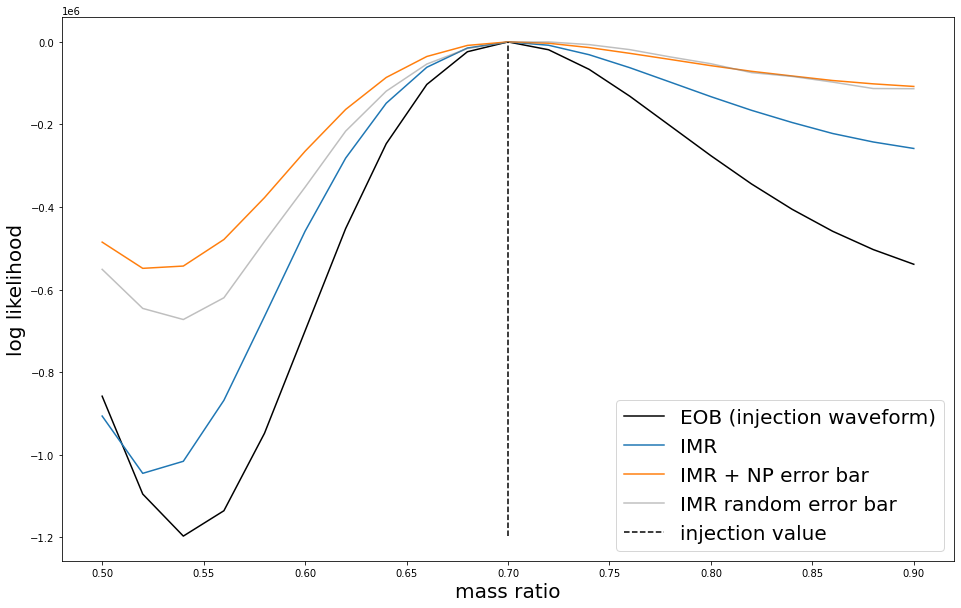

In [11]:
plt.figure(figsize=(16,10))
plt.plot(qlist, llist_EOB_norm, label='EOB (injection waveform)', color='k')

plt.plot(qlist, llist_IMR_norm, label='IMR')
plt.plot(qlist, llist_IMRmod_norm, label='IMR + NP error bar')
plt.plot(qlist, llist_IMRrandmod10_norm, label='IMR random error bar', color='grey',alpha=0.5)
plt.vlines(x=q_real,ymin=min(llist_EOB_norm), ymax=max(llist_EOB_norm), label='injection value', color='k', linestyle='--')
plt.legend(fontsize=20)

plt.ylabel('log likelihood',fontsize=20)
plt.xlabel('mass ratio',fontsize=20)

#plt.xlim(0.65,0.75)
#plt.ylim(-1500,200)
plt.show()

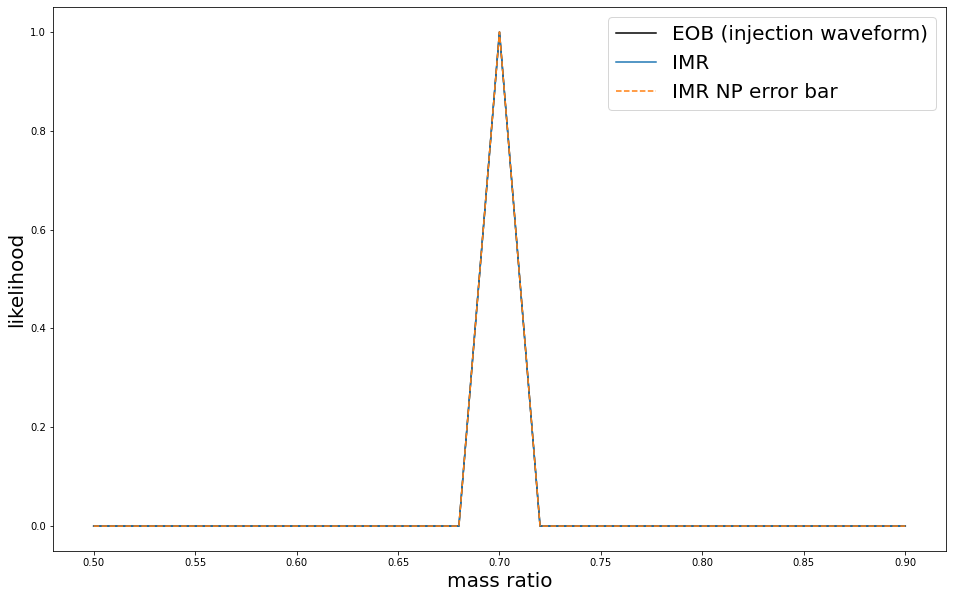

In [12]:
plt.figure(figsize=(16,10))
plt.plot(qlist, np.exp(llist_EOB_norm), label='EOB (injection waveform)', color='k')

plt.plot(qlist, np.exp(llist_IMR_norm), label='IMR')
plt.plot(qlist, np.exp(llist_IMRmod_norm), label='IMR NP error bar',linestyle='--')
#plt.plot(qlist, llist_IMRrandmod10_norm, label='IMR random error bar', color='grey',alpha=0.5)
#plt.vlines(x=q_real,ymin=min(llist_EOB_norm), ymax=max(llist_EOB_norm), label='injection value', color='k', linestyle='--')
plt.legend(fontsize=20)

plt.ylabel('likelihood',fontsize=20)
plt.xlabel('mass ratio',fontsize=20)

#plt.ylim(-1500,200)
plt.show()